In [7]:
import logging 
import numpy as np 
import time

import gym
from gym import spaces
#from gym.envs.classic_control import rendering
from ipynb.fs.full.camera import CameraClient
from ipynb.fs.full.scanner import ScannerClient
import matplotlib.pyplot as plt
import scipy
from skimage.measure import label, regionprops
import skimage.filters as skfilt
import random

logging.getLogger().setLevel(logging.INFO)

In [8]:
class LaserReachEnv(gym.GoalEnv):   
   
    def __init__(self, distance_threshold, img_size, laser_range, dot_detection_threshold, max_episode_steps, training = True, reward_type = 'shaped'):
        
        self.img_size = img_size
        self.laser_range = laser_range
        self.training = training
        self.reward_type = reward_type
        self.distance_threshold = distance_threshold 
        self.dot_detection_threshold = dot_detection_threshold
        self.max_episode_steps = max_episode_steps 
        
        logging.info("Initialization of scanner environment")
       
        # -- establish connection to hardware devices
        self.scanner = ScannerClient()
        self.cam = CameraClient()
        
        # -- initialize the spaces
        self.action_space = spaces.Box(-1., 1., shape = (2,), dtype=np.float32)  # mirror_x, mirror_y              
        self.observation_space = spaces.Dict({
             'observation': spaces.Box(-1., 1., shape=(2,),  dtype='float32'),
             'achieved_goal': spaces.Box(-1., 1., shape=(2,), dtype='float32'),
             'desired_goal': spaces.Box(-1., 1., shape=(2,), dtype='float32')
            })
       

    def step(self, action):
        rescaled_action = self._rescale_action(action)
        self.scanner.jump(rescaled_action[0], rescaled_action[1])
        
        self.current_mirr_pos = action       
        time.sleep(0.1)
        
        self.current_beam_pos = self.detect_beam()
      
        if self.current_beam_pos is None:
            self.current_beam_pos = self.goal
            
        obs = self._get_obs()
        
        self.current_step += 1
        done = False
        info = {
            'is_success': self._is_success(obs['achieved_goal'], obs['desired_goal']),
        }
        if self.current_step >= self.max_episode_steps or info['is_success']:
            done = True
        reward = self.compute_reward(obs['achieved_goal'], obs['desired_goal'], info)
        return obs, reward, done, info
     
        
    def compute_reward(self, achieved_goal, goal, info):        
        # Compute distance between goal and the achieved goal.
        d = np.linalg.norm(achieved_goal - goal, axis=-1)
        if self.reward_type == 'shaped':
            return -d
        else:
            return (d < self.distance_threshold).astype(np.float)
        
        
    # start up function prior every episode
    def reset(self):
        self.current_step = 0
        if self.training:
            self.goal = self._sample_goal().copy()
        else:
            self.goal = self._detect_goal().copy()
        
        self.current_mirr_pos = self._sample_random_scanner_pos_and_jump()
        self.current_beam_pos = self.detect_beam()
        obs = self._get_obs()

        return obs   
  

    def detect_beam(self):
        img = self.cam.take_picture()
        # -- smooth and find a threshold
        thresh_val = skfilt.threshold_otsu(img)
        img = scipy.ndimage.gaussian_filter(img, sigma=1)
        laser_mask = img > thresh_val
        
        # -- label image regions 
        label_laser = label(laser_mask)
        props_laser = regionprops(label_laser)
        if len(props_laser) > 1 or len(props_laser) == 0: 
            return None
        return np.array(props_laser[0].centroid, dtype=np.float32)
    
    
    def render(self):
        raise NotImplementedError()

 
    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None   
        
        
    def _get_obs(self):
        desired_goal_scaled = self._scale_goal(self.goal.copy())
        achieved_goal_scaled = self._scale_goal(self.current_beam_pos.copy())
        return {
            'observation': self.current_mirr_pos.copy(),      
            'achieved_goal': achieved_goal_scaled,         
            'desired_goal': desired_goal_scaled                    
        }        
        
        
    def _detect_goal(self):
        img = self.cam.take_picture()
        
        dot_mask = img < self.dot_detection_threshold
        # label the region
        label_dot = label(dot_mask)
        props_dot = regionprops(label_dot)

        return np.array(props_dot[0].centroid, dtype=np.float32)
    
    
    def _sample_goal(self):
        goal = [random.uniform(0, self.img_size[0]), random.uniform(0, self.img_size[1])]
        return goal.copy()
    
    
    def _sample_random_scanner_pos_and_jump(self):
        init_pos = np.array([-0.04814815, 0.], dtype=np.float32)
        rescaled_pos = self._rescale_action(init_pos)
        self.scanner.jump(rescaled_pos[0], rescaled_pos[1])
        time.sleep(0.1)
        return init_pos
    
    
    def _is_success(self, achieved_goal, desired_goal):
        d = np.linalg.norm(achieved_goal - desired_goal, axis=-1)
        return (d < self.distance_threshold)
    
    
    def _rescale_action(self, action):
        x_min = self.laser_range[0][0]
        x_max = self.laser_range[0][1]
        
        y_min = self.laser_range[1][0]
        y_max = self.laser_range[1][1]        
        
        low=np.array([x_min, y_min])
        high=np.array([x_max, y_max]) 
        return low + (0.5 * (action + 1.0) * (high - low))
    
    
    def _scale_goal(self, goal):
        low = np.array([0, 0])
        high = np.array([self.img_size[0], self.img_size[1]])
        return 2.0 * ((goal - low) / (high - low)) - 1.0


In [ ]:
def scale_goal(goal):
    low = np.array([0, 0])
    high = np.array([600, 800])
    return 2.0 * ((goal - low) / (high - low)) - 1.0

goal1 = np.array([372, 739])
goal2 = np.array([361, 698])
d = np.linalg.norm(goal2 - goal1, axis=-1)
#d = np.linalg.norm(goal2 - goal1, axis=-1)
print(d)

In [ ]:
laser_range = np.array([[-95000, 68000],[53000, 170000]])
img_size = [600, 800]
env = LaserReachEnv(0.1, img_size, laser_range, 20, 50, True, 'binary')
episodes = 1
for episode in range(episodes):
    state = env.reset()
    score = 0
    for _ in range (1):
        action = env.action_space.sample()
        print(action)
        obs, reward, is_done, info = env.step(action)
        print(obs)
        print(info)
        score += reward
    print('Episode {} score is: {}'.format(episode, score))

In [ ]:
from stable_baselines3 import HER, DDPG, TD3, SAC
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
import os

TEST = 'her_sac_3_binary_full_final'

class SaveOnBestTrainingRewardCallback(BaseCallback):

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.best_mean_reward = -np.inf

        
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean training reward over the last episodes
                mean_reward = np.mean(y[-self.check_freq:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
        return True

    
log_dir =  os.path.join('logs/', TEST)

os.makedirs(log_dir, exist_ok=True)

# init environment
laser_range = np.array([[-95000, 68000],[53000, 170000]])
img_size = [600, 800]
env = LaserReachEnv(0.12, img_size, laser_range, 20, 3, True, 'binary')
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

# Create the callback: check every 500 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=500, log_dir=log_dir, verbose=1)

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

goal_selection_strategy = 'future' 
policy_kwargs = dict(net_arch=[256, 256, 256])

# Initialize the model
model = HER('MlpPolicy', 
            env, 
            SAC, 
            n_sampled_goal=8, 
            goal_selection_strategy=goal_selection_strategy, 
            online_sampling=True,
            verbose=0, 
            max_episode_length=3, 
            learning_rate=0.001, 
            action_noise = action_noise, 
            learning_starts=1000,
            gamma=0.95, 
            batch_size=256, 
            policy_kwargs = policy_kwargs, 
            )
# Train the model
model.learn(30000, callback=callback)
model.save(os.path.join('models/', TEST))

INFO:root:Initialization of scanner environment
INFO:root:Connection to scanner service established
INFO:root:Connection to camera service established


Goal is [388.88459568 330.24711349]
action is [-0.17981881 -0.29176676]


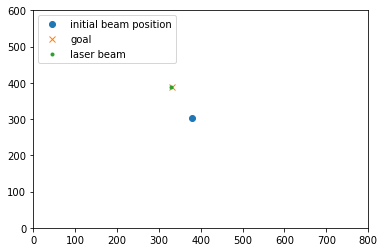

In [103]:
from stable_baselines3 import HER, DDPG, TD3, SAC
import matplotlib.patches as patches
from matplotlib.patches import Rectangle


TEST = 'her_sac_3_shaped_full_final'
laser_range = np.array([[-95000, 68000],[53000, 170000]])
img_size = [600, 800]

def scale_goal(goal):
    low = np.array([0, 0])
    high = np.array([img_size[0], img_size[1]])
    return low + (0.5 * (goal + 1.0) * (high - low))


env = LaserReachEnv(0.12, img_size, laser_range, 10, 3, True, 'shaped')
model = HER.load(os.path.join('models/', TEST), env=env)

done = False 
i = 0 
for _ in range(1):
    plt.figure()
    plt.xlim(0, img_size[1])
    plt.ylim(0, img_size[0])
    plt.legend()
    
    obs = env.reset()
    goal = scale_goal(obs["desired_goal"])
    initial = scale_goal(obs["achieved_goal"])
    plt.plot(initial[1], initial[0], "o", label="initial beam position")
    print("Goal is {0}".format(goal))
    plt.plot(goal[1], goal[0], "x", label = "goal")
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        print('action is {}'.format(action))
        obs, reward, done, _ = env.step(action)
        achieved_goal = scale_goal(obs["achieved_goal"])
        plt.plot(achieved_goal[1], achieved_goal[0], ".", label="laser beam")
    plt.legend(loc="upper left")
    #plt.savefig(str(i) + ".png")
    i+=1
    plt.show()
    time.sleep(2)
    

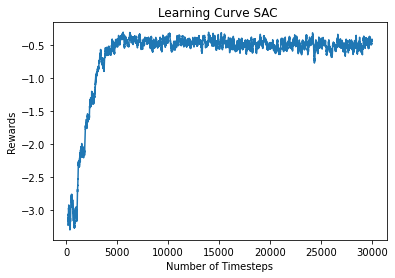

In [104]:
from stable_baselines3.common import results_plotter

TEST = 'her_sac_3_shaped_full_final'
log_dir =  os.path.join('logs/', TEST)
# Helper from the library
#results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "SAC Laser pointer")


def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve SAC '):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]
    
    
    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title)
    plt.savefig("her_sac_3_shaped.png")
    plt.show()


plot_results(log_dir)
